In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
from joblib import load
from datetime import datetime, timezone
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, fixed
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')

In [3]:
model_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP'
preds_2023 = pd.read_csv(os.path.join(model_dir, 'YDC.P.preds.holdout.csv'))
scaler = load(os.path.join(model_dir, 'YDC.P.scaler.joblib'))

In [4]:
preds_2023['residual'] = preds_2023['magnitude'] - preds_2023['predicted_magnitude']

In [5]:
stat = "YDC"
proc = GatherFeatureDatasets(is_p=True)
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        test_df=all_test_df,
                                                                                        holdout_df=all_holdout_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)


In [6]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')

In [7]:
feature_plot_names

array(['ratio 1', 'ratio 2', 'ratio 3', 'ratio 4', 'ratio 5', 'ratio 6',
       'ratio 7', 'ratio 8', 'ratio 9', 'ratio 10', 'ratio 11',
       'ratio 12', 'ratio 13', 'ratio 14', 'ratio 15', 'ratio 16',
       'ratio 17', 'ratio 18', 'amp. 1', 'amp. 2', 'amp. 3', 'amp. 4',
       'amp. 5', 'amp. 6', 'amp. 7', 'amp. 8', 'amp. 9', 'amp. 10',
       'amp. 11', 'amp. 12', 'amp. 13', 'amp. 14', 'amp. 15', 'amp. 16',
       'amp. 17', 'amp. 18', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'distance', 'back az.'], dtype='<U15')

In [8]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
feature_inds = np.where(np.isin(feature_names, selected_features))[0]

In [9]:
X_train = station_feature_dict['X_train']
X_holdout = station_feature_dict['X_holdout']

In [10]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [11]:
def plot_features(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    subpanel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
    sp_ind = 0
    good_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) > 0.5].Evid))
    print(bad_ind)
    cmap = matplotlib.colormaps["viridis"]
    norm = plt.Normalize(bad_ind[0].min(), bad_ind[0].max())
    edge_colors = cmap(norm(bad_ind[0]))

    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        s1 = ax.scatter(y_train, X_train[:, find], s=20, alpha=0.1, color='#737373', label='Train')
        s2 = ax.scatter(y_test[good_ind], X_test[good_ind, find], s=20, facecolors='none', edgecolor='k',
                   label='Test B')
        s3 = ax.scatter(y_test[bad_ind], 
                        X_test[bad_ind, find], 
                        s=20, 
                        #c=bad_ind[0],
                        #cmap='viridis',
                        facecolors='none', 
                        edgecolor=edge_colors, #'#fc9272', 
                        label='Test B - large resid.')
        if i == 0:
            legend_items = [s1, s2, s3]
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        ax.set_xticks(np.arange(0, 5))
        if i < 4:
            ax.set_xticklabels([])

        ax.text(0, 1.04, subpanel_labels[sp_ind], 
        transform=ax.transAxes,)
        sp_ind += 1
        i += 1

    axes[3].legend(legend_items, 
                   ['Train', 'Test B', 'Test B,\n|resid.| > 0.5'], 
                   loc='center',
                   handletextpad=0.2, borderpad=0.2, handlelength=1.0,
                   labelspacing=1.0)

    fig.supxlabel('$M_{L,YP21}$')
    fig.supylabel("Feature Value")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

In [12]:
feature_inds

array([18, 19, 40, 41, 42, 43, 44])

(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28]),)


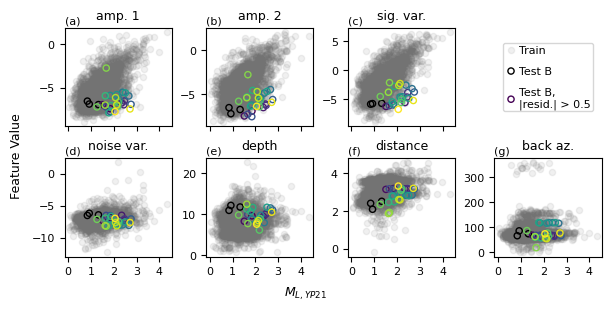

In [13]:
plot_features(X_train, station_meta_dict['y_train'], 
              X_holdout, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              feature_inds, feature_plot_names,)
              #savefigname='../figures/examineFeatureDistsYDC.png')

(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28]),)


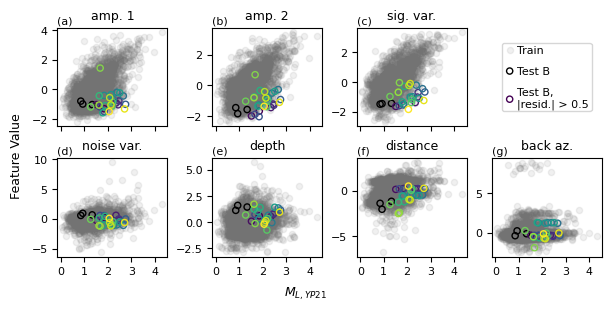

In [14]:
# The distributions should look the same whether they are scaled or not...
X_train_s = scaler.transform(X_train[:, feature_inds])
X_holdout_s = scaler.transform(X_holdout[:, feature_inds])
plot_features(X_train_s, station_meta_dict['y_train'], 
              X_holdout_s, station_meta_dict['y_holdout'], 
              station_meta_dict['evids_holdout'], preds_2023,
              np.arange(0, 7), feature_plot_names[feature_inds],)
              #savefigname='../figures/examineFeatureDistsYDCScaled.png')

# Look at each example separately  

In [15]:
def plot_features_single_holdout_ex(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None,
                  ylim=[0, 6],
                  sharey=False):
    fig, axes = plt.subplots(2, 4, 
                            constrained_layout=True, figsize=(6, 3), sharey=sharey)
    axes = axes.flatten()
    i = 0
    subpanel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
    sp_ind = 0
    good_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[abs(test_preds.residual) > 0.5].Evid))

    for find in feature_inds:
        ax = axes[i]
        if ylim is not None:
            ax.set_ylim(ylim)
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        s1 = ax.scatter(y_train, X_train[:, find], s=20, alpha=0.1, color='#737373', label='Train')
        if len(good_ind[0]) > 0:
            s2 = ax.scatter(y_test[good_ind], X_test[good_ind, find], s=20, facecolors='none', edgecolor='k',
                    label='Test B')
        if len(bad_ind[0]) > 0:
            s3 = ax.scatter(y_test[bad_ind], 
                X_test[bad_ind, find], 
                s=20, 
                facecolors='none', 
                edgecolor='#fc9272', 
                label='Test B - large resid.')

        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        ax.set_xticks(np.arange(0, 5))
        if i < 4:
            ax.set_xticklabels([])

        ax.text(0, 1.04, subpanel_labels[sp_ind], 
        transform=ax.transAxes,)
        sp_ind += 1
        i += 1

    fig.supxlabel('$M_{L,YP21}$')
    fig.supylabel("Feature Value")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

/tmp/ipykernel_3940294/949415031.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 4,


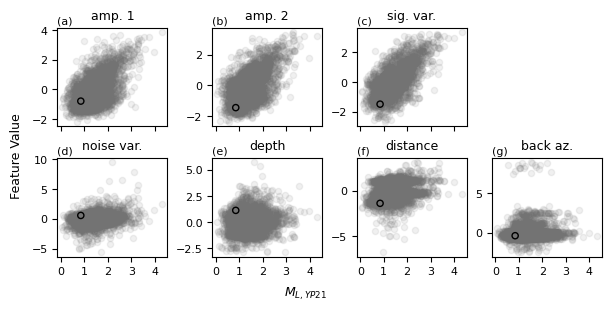

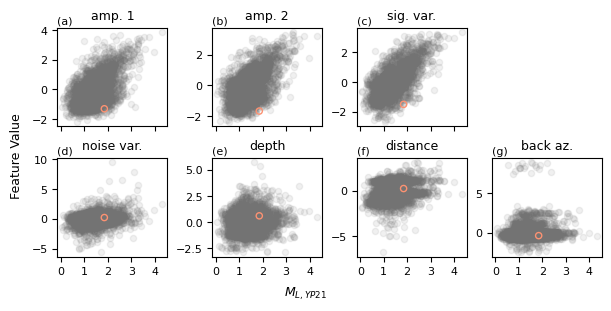

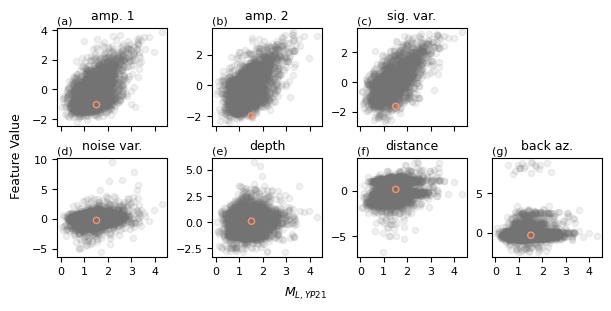

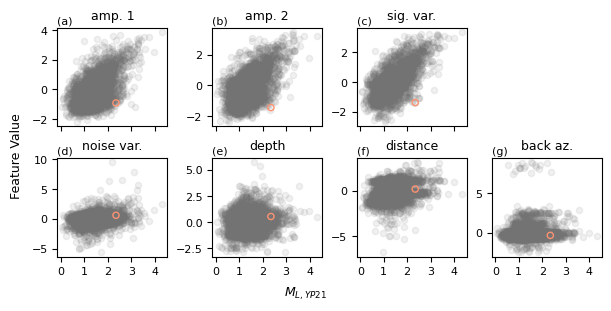

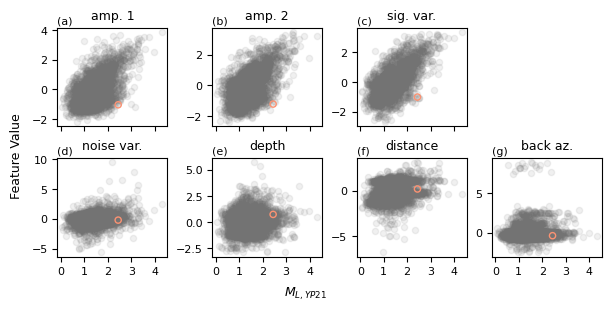

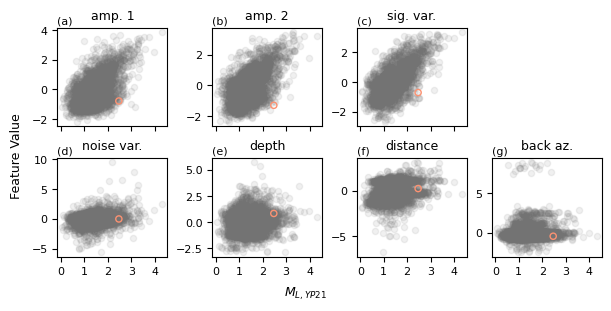

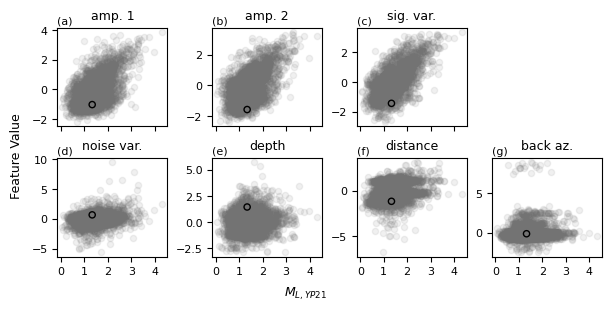

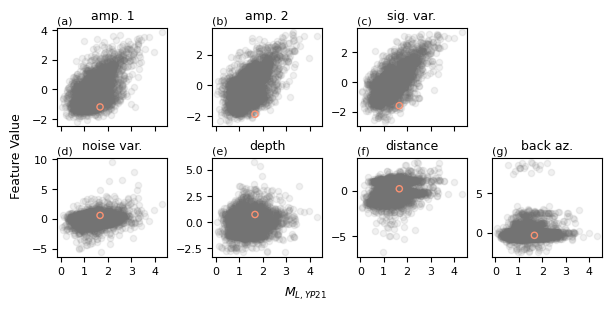

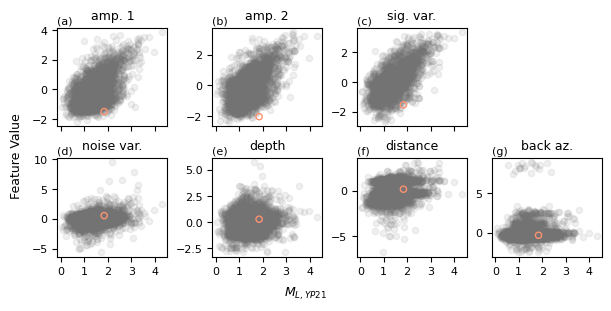

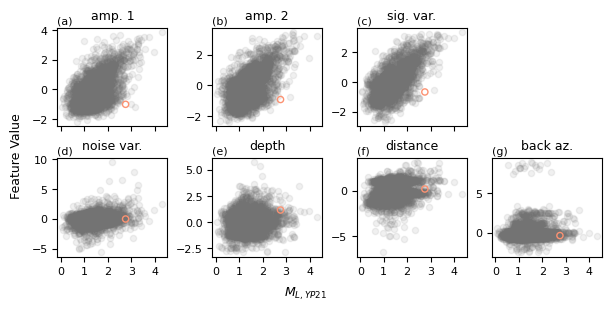

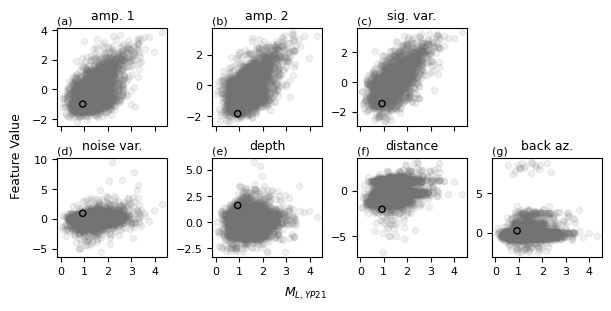

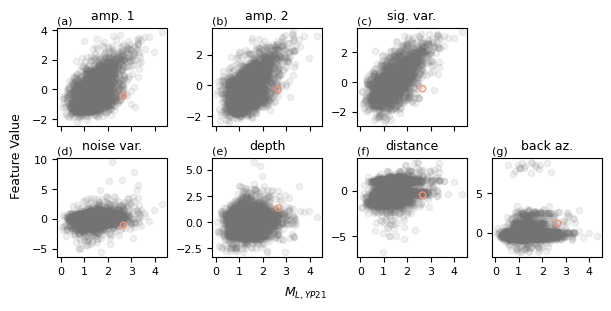

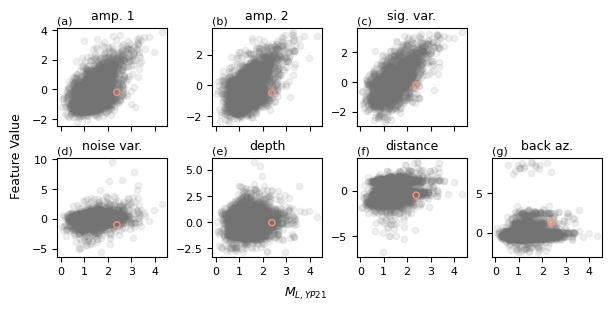

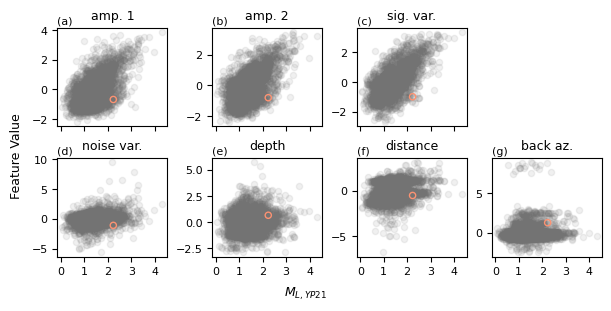

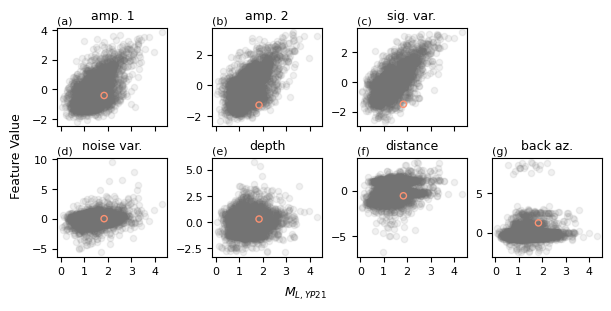

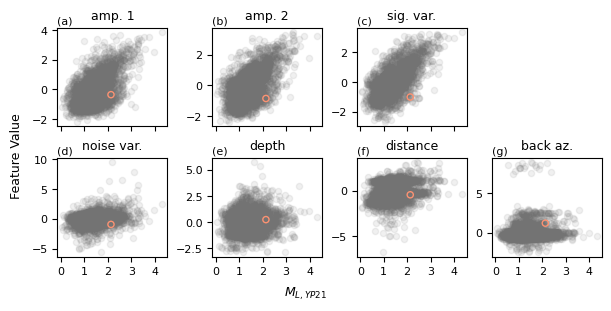

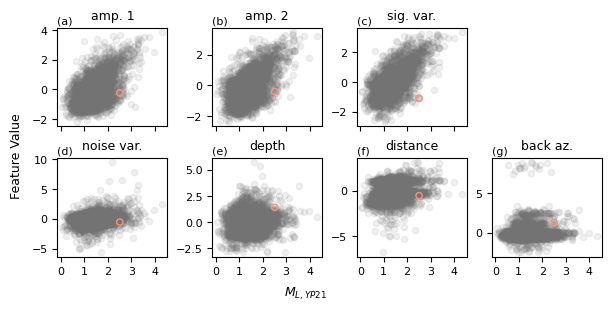

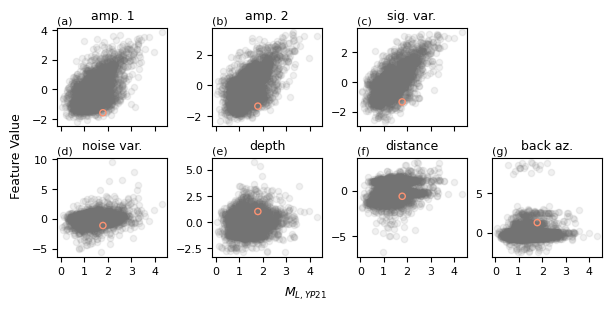

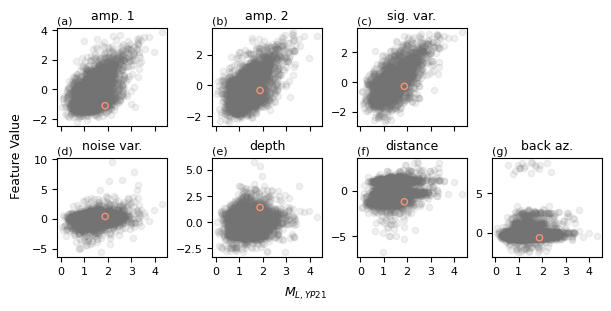

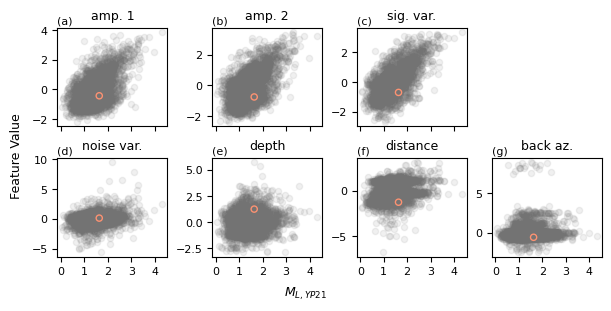

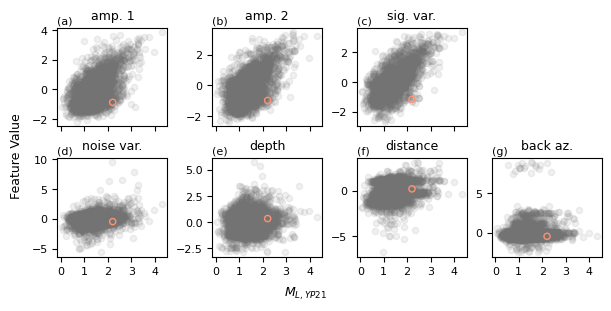

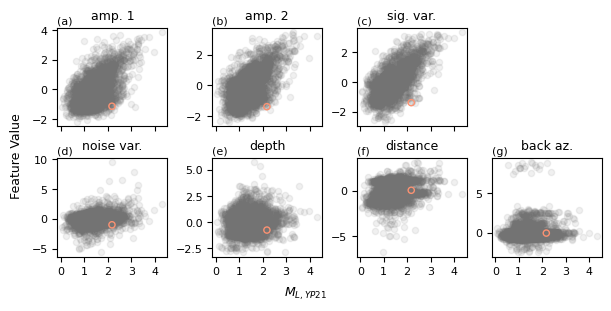

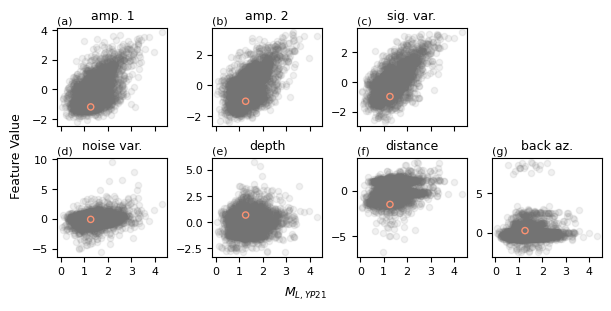

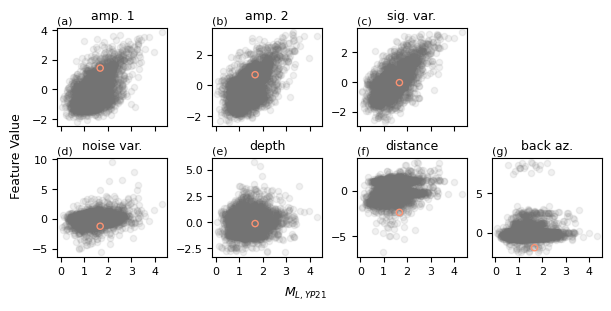

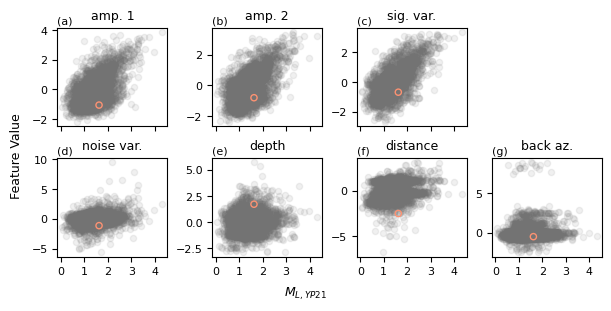

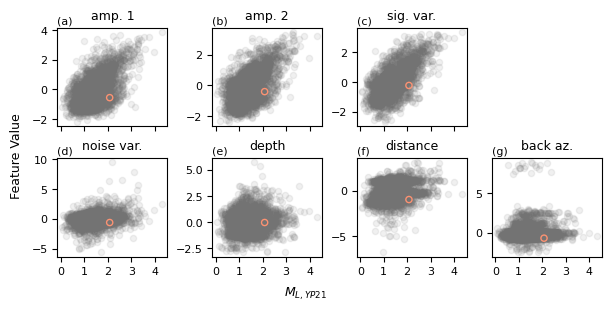

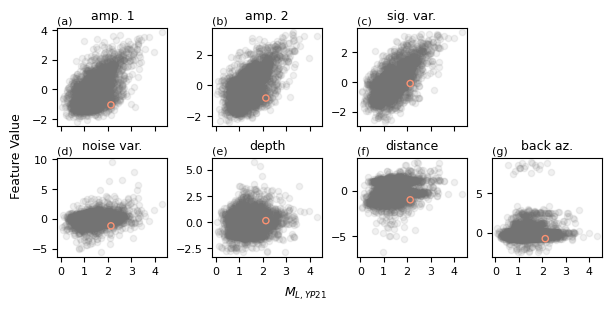

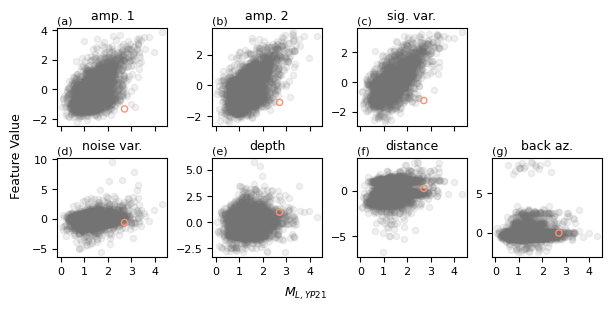

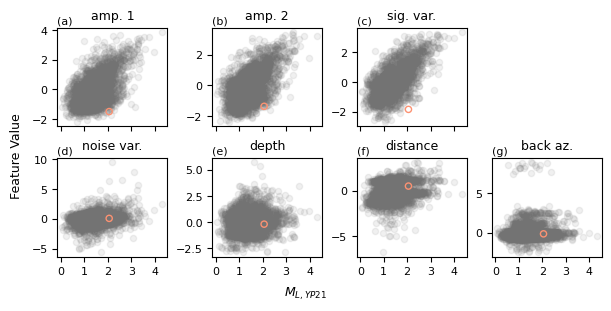

In [16]:
for i in range(X_holdout.shape[0]):
    plot_features_single_holdout_ex(X_train_s, station_meta_dict['y_train'], 
                X_holdout_s[i:i+1, :], station_meta_dict['y_holdout'][i:i+1], 
                station_meta_dict['evids_holdout'][i:i+1], preds_2023,
                np.arange(0, 7), feature_plot_names[feature_inds], ylim=None)

# Use histograms instead of scatter plots

In [17]:
def plot_hist(X_train, 
                  X_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    for find in feature_inds:
        ax = axes[i]
        if i == 3:
            ax.axis('off')
            i += 1
            ax = axes[i]
        ax.hist(X_train[:, find], color='#737373')
        good_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual <= 0.5].Evid))
        bad_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual > 0.5].Evid))
        ax.hist(X_test[bad_ind, find].flatten(), color='#fc9272')
        ax.hist(X_test[good_ind, find].flatten(), color='k')
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        if i < 4:
            ax.set_xticklabels([])
        i += 1

    fig.supxlabel('Feature Value')
    fig.supylabel("Counts")

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)

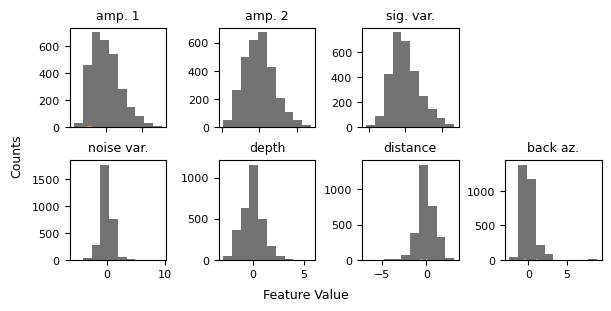

In [18]:
plot_hist(X_train_s,  
            X_holdout_s, 
            station_meta_dict['evids_holdout'], preds_2023,
            np.arange(0, 7), feature_plot_names[feature_inds])

In [19]:
def plot_hist_single_heldout_ex(X_train, 
                  y_train,
                  X_test, 
                  test_evids,
                  test_preds, 
                  feature_inds,
                  feature_plot_names,
                  savefigname=None):
    fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))
    axes = axes.flatten()
    i = 0
    good_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual <= 0.5].Evid))
    bad_ind = np.where(np.isin(test_evids, test_preds[test_preds.residual > 0.5].Evid))
    for find in feature_inds:
        ax = axes[i]
        ax.hist(X_train[:, find], color='#737373')
        if len(bad_ind[0]) > 0:
            ax.axvline(X_test[bad_ind, find].flatten(), color='#fc9272')
        else:
            ax.axvline(X_test[good_ind, find].flatten(), color='k')
        ax.set_title(feature_plot_names[find])
        #ax.set_yticklabels([])
        # if i < 4:
        #     ax.set_xticklabels([])
        i += 1

    ax = axes[i]
    ax.hist(y_train, color='#737373')
    if len(bad_ind[0]) > 0:
        ax.axvline(test_preds.iloc[bad_ind[0][0]].magnitude, color='#fc9272')
    else:
        ax.axvline(test_preds.iloc[good_ind[0][0]].magnitude, color='k')
    ax.set_title("$M_{L,YP21}$")    
    fig.supxlabel('Feature Value')
    fig.supylabel("Counts")

/tmp/ipykernel_3940294/3876559148.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 4, constrained_layout=True, figsize=(6, 3))


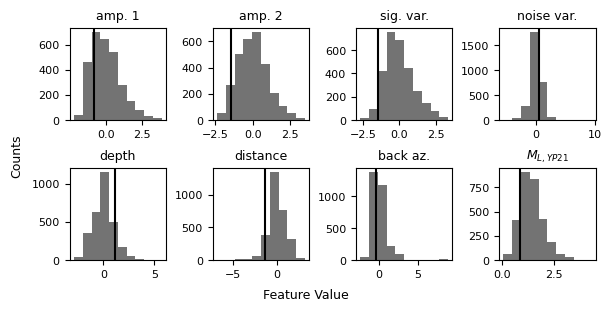

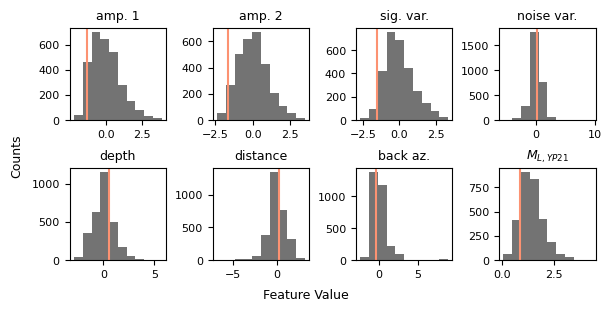

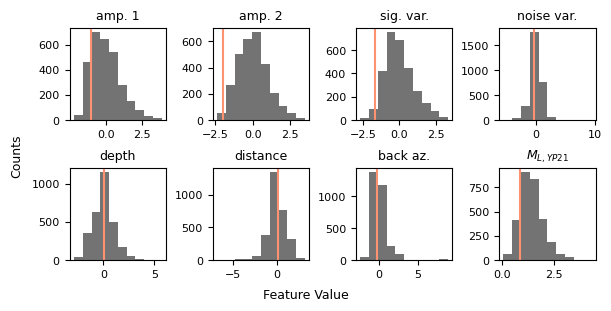

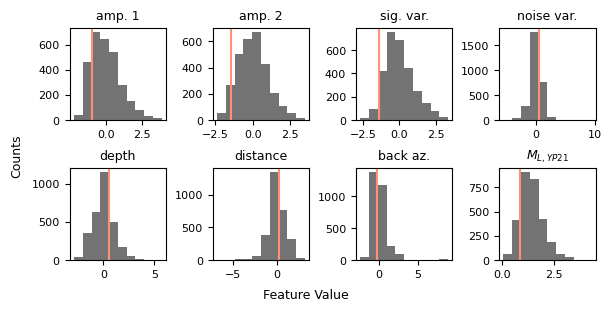

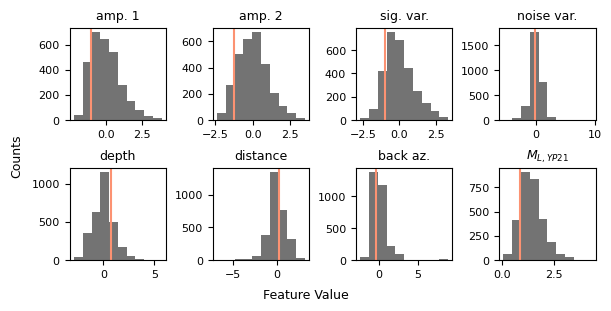

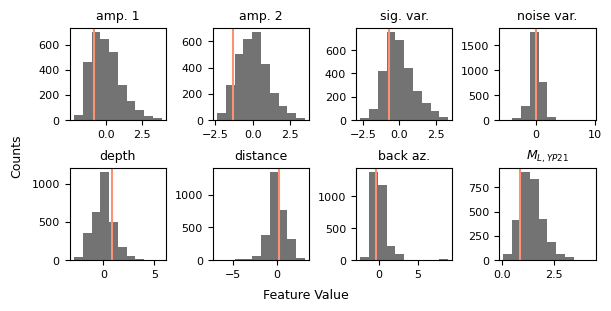

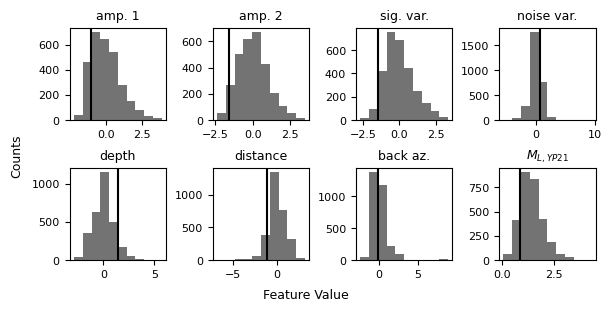

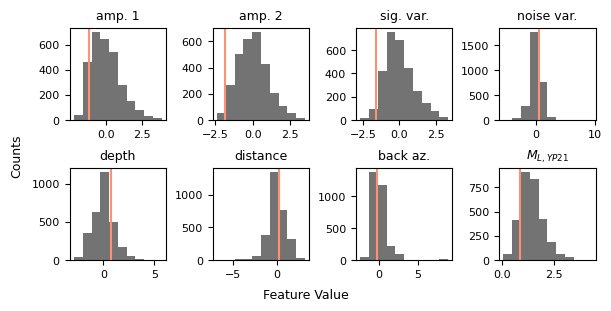

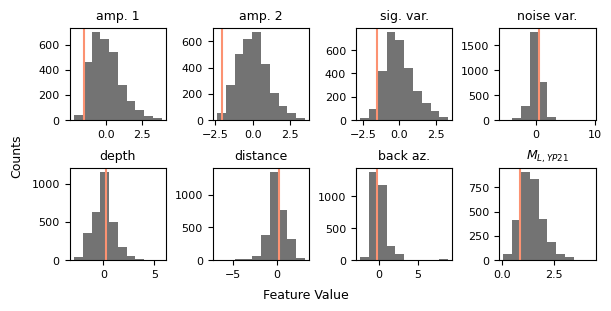

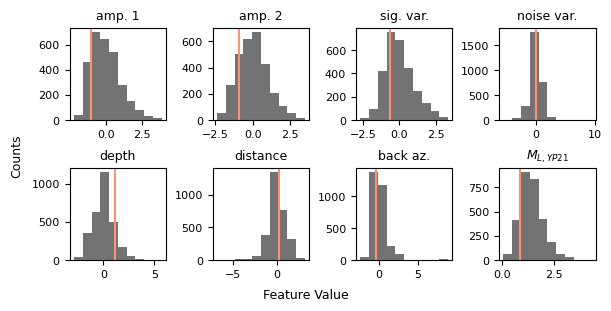

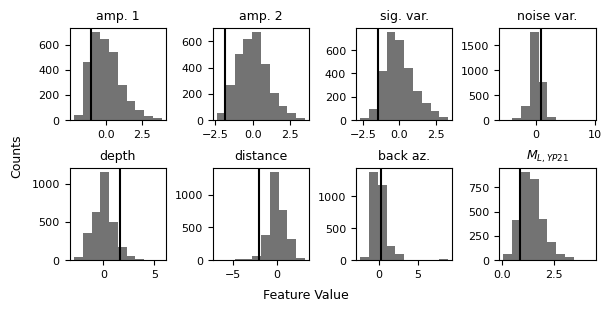

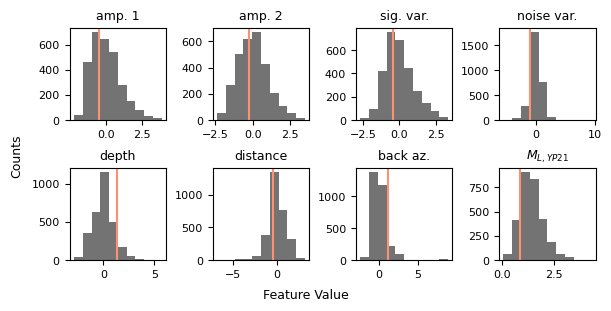

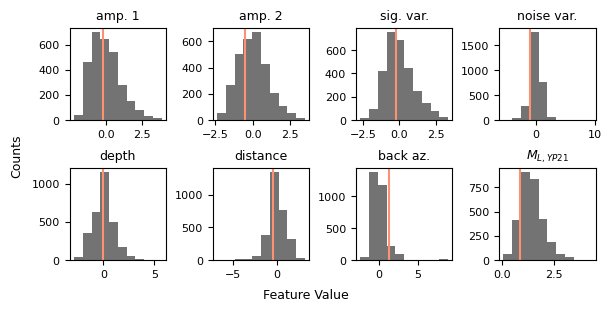

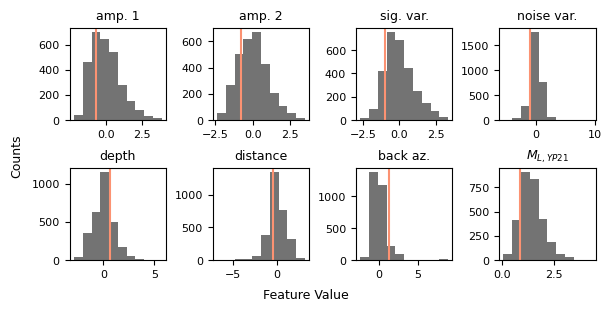

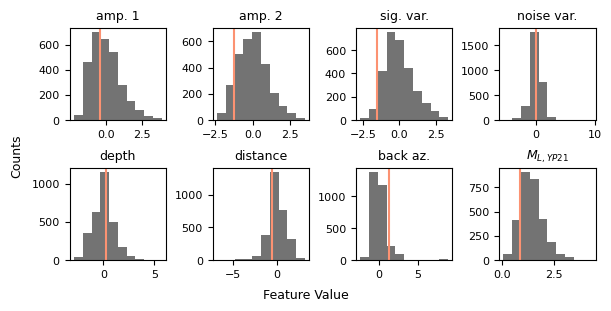

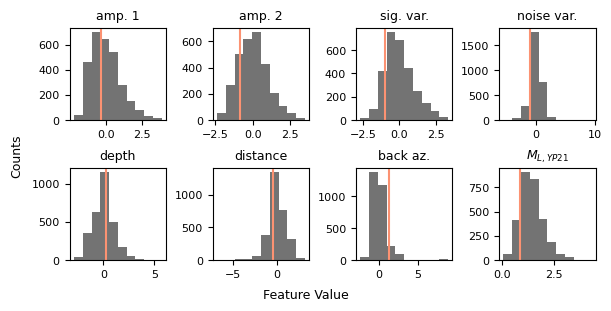

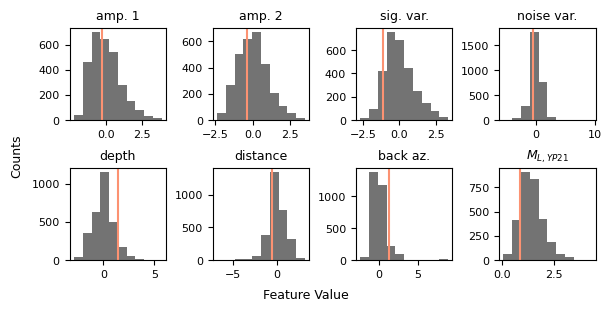

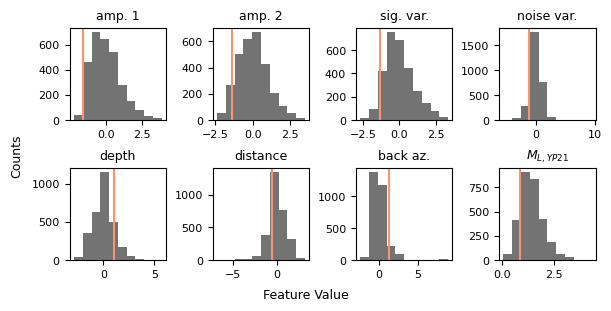

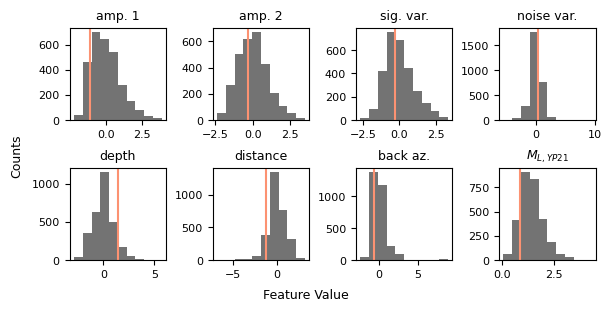

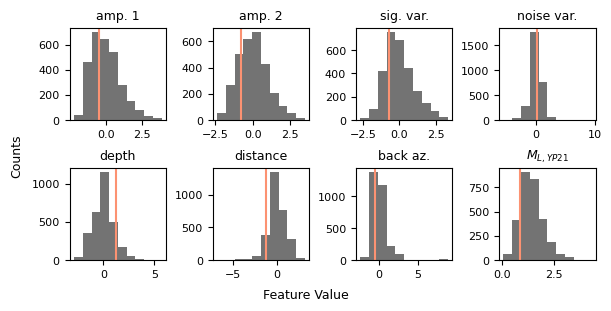

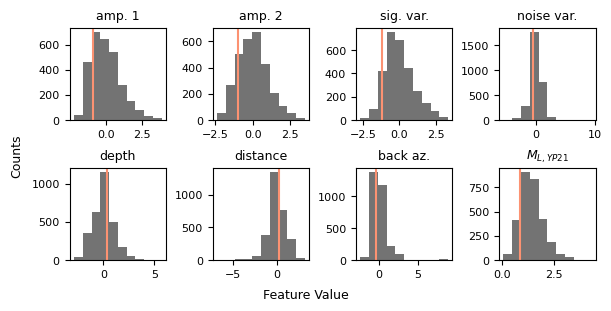

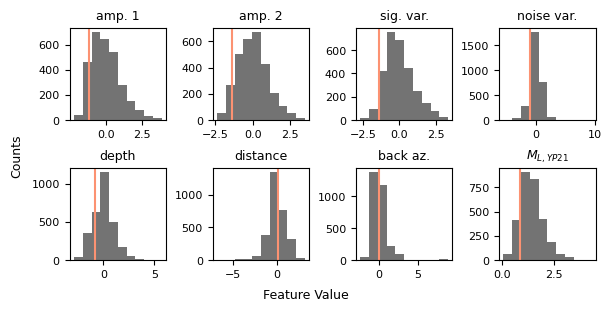

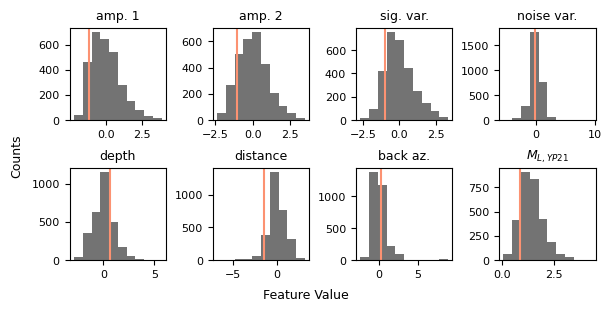

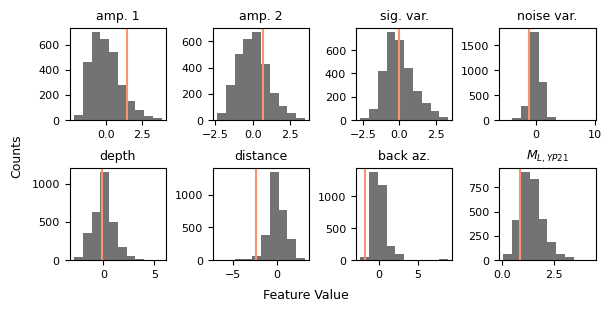

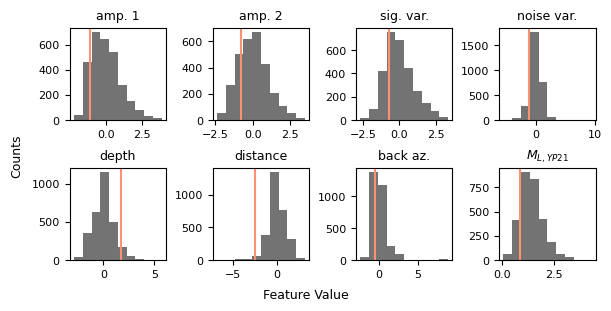

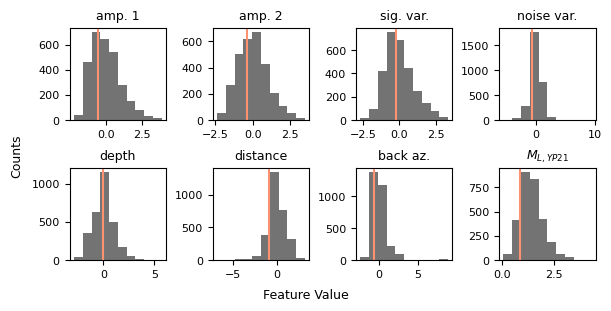

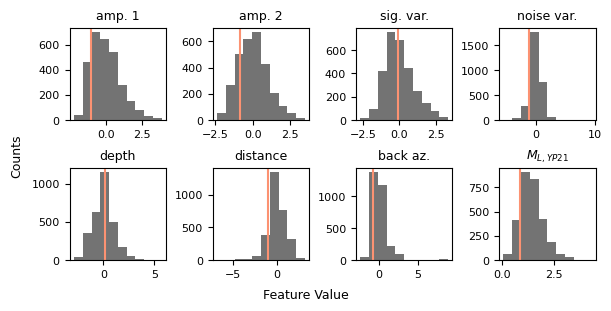

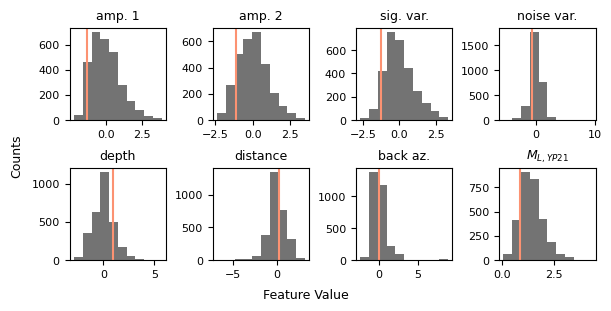

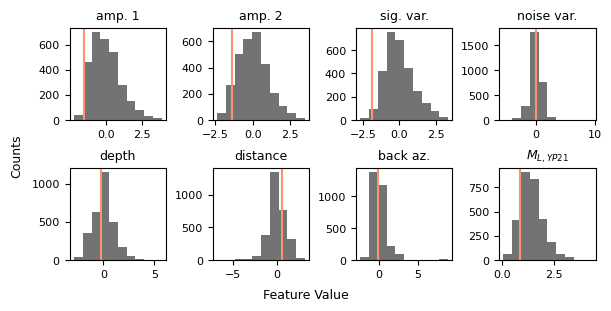

In [20]:
for i in range(X_holdout.shape[0]):
    plot_hist_single_heldout_ex(X_train_s,  
                                station_meta_dict['y_train'],
                                X_holdout_s[i:i+1, :], 
                                station_meta_dict['evids_holdout'][i:i+1], preds_2023,
                                np.arange(0, 7), feature_plot_names[feature_inds])